<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
import os
#import imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ls_r_path(path):
    return sorted(["{}/{}".format(root, f) for root, _, files in os.walk(path) for f in files])

In [3]:
data_dir = "../data/"
train_dir = data_dir + "training/"
test_dir = data_dir + "test_set_images/"

path_x_tr = ls_r_path(train_dir + "images")
path_y_tr = ls_r_path(train_dir + "groundtruth")
path_x_te = ls_r_path(test_dir)

In [4]:
sample_size = 10 

In [5]:
np.array(Image.open(path_x_tr[0]))

array([[[ 85,  77,  69],
        [ 81,  75,  67],
        [ 78,  72,  64],
        ..., 
        [ 81,  80,  75],
        [ 77,  77,  73],
        [ 78,  78,  74]],

       [[ 82,  74,  67],
        [ 78,  73,  64],
        [ 77,  72,  62],
        ..., 
        [ 81,  81,  76],
        [ 80,  80,  74],
        [ 81,  82,  78]],

       [[ 83,  77,  69],
        [ 81,  73,  65],
        [ 80,  74,  65],
        ..., 
        [ 81,  81,  75],
        [ 80,  80,  74],
        [ 81,  81,  77]],

       ..., 
       [[  7,   8,   5],
        [  9,  10,   7],
        [ 15,  15,  13],
        ..., 
        [ 85,  83,  72],
        [ 84,  82,  73],
        [ 74,  71,  60]],

       [[ 11,  11,   7],
        [  9,   9,   4],
        [  8,   8,   4],
        ..., 
        [197, 195, 177],
        [193, 192, 175],
        [205, 203, 187]],

       [[  5,   5,   2],
        [  9,  10,   6],
        [ 12,  14,   9],
        ..., 
        [179, 178, 165],
        [163, 160, 147],
        [106, 104,

In [6]:
x_train = np.array([np.array(Image.open(p)) for p in path_x_tr[:sample_size]])
x_train.shape

(10, 400, 400, 3)

In [7]:
y_train = np.array([np.array(Image.open(p)) for p in path_y_tr[:sample_size]])
y_train.shape

(10, 400, 400)

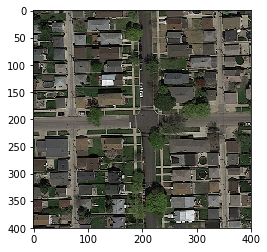

In [8]:
plt.imshow(x_train[0])
plt.show()

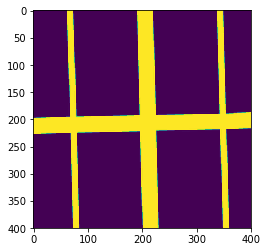

In [9]:
plt.imshow(y_train[0])
plt.show()

In [10]:
x_test = x_train.copy()
y_test = y_train.copy()

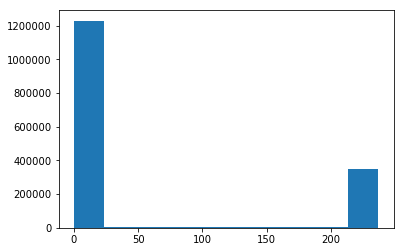

In [11]:
plt.hist(y_train.flatten())
plt.show()

In [20]:
from segnet import segnet
from densenet import preprocess_input, DenseNet

import keras

ModuleNotFoundError: No module named 'keras_contrib'

In [19]:
model = segnet(2, keras.optimizers.Adam(), 400, 400)

C:\Users\cleme\Programming\Python\ML_2017\Projects\project02\src\segnet.py:29: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="valid")`
  model.add(Convolution2D(filter_size, kernel, kernel, border_mode='valid'))
C:\Users\cleme\Programming\Python\ML_2017\Projects\project02\src\segnet.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="valid")`
  model.add(Convolution2D(128, kernel, kernel, border_mode='valid'))


ValueError: Negative dimension size caused by subtracting 2 from 1 for 'max_pooling2d_10/MaxPool' (op: 'MaxPool') with input shapes: [?,1,200,128].

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import matplotlib.pylab as plt

batch_size = 10#128
num_classes = 2
epochs = 10

# input image dimensions
img_x, img_y = 400, 400

# load the MNIST data set, which already splits into train and test sets for us
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.array([np.array(Image.open(p)) for p in path_x_tr[sample_size:]])
y_train = np.array([np.array(Image.open(p)) for p in path_y_tr[sample_size:]])
x_test = np.array([np.array(Image.open(p)) for p in path_x_tr[:sample_size]])
y_test = np.array([np.array(Image.open(p)) for p in path_y_tr[:sample_size]])

# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
# because the MNIST is greyscale, we only have a single channel - RGB colour images would have 3
#x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 3)
#x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 3)
input_shape = (img_x, img_y, 3)

# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=1000, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()

model.fit(x_train, y_train,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 11), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()